In [1]:
import numpy as np
import pandas as pd
import requests
import subprocess
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import layers

import keras


from sklearn.preprocessing import PowerTransformer, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def metrics_evals(y_true,y_pred, X_test):
    mse = mean_squared_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    adj_r2 = 1 - (1-r2)*(len(y_true)-1)/(len(y_true)-X_test.shape[1]-1)

    return {"MSE":mse, 
            "RMSE":rmse, 
            "MAE":mae, 
            "R2":r2,
            "ADJ_R2": adj_r2}

import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# For Reproducibility
np.random.seed(42)
tf.random.set_seed(42)



data_link = "https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/015/039/original/dataset.csv.zip?1663710760"



def download_url(url, save_path, chunk_size=128):
    r = requests.get(url, stream=True)
    with open(save_path, 'wb') as fd:
        for chunk in r.iter_content(chunk_size=chunk_size):
            fd.write(chunk)

download_url(url=data_link, save_path='data/dataset.zip')

# importing required modules
from zipfile import ZipFile

# specifying the zip file name
file_name = "my_python_files.zip"

# opening the zip file in READ mode
with ZipFile('data/dataset.zip', 'r') as zip:
	# printing all the contents of the zip file
	zip.printdir()

	# extracting all the files
	print('Extracting all the files now...')
	zip.extractall()
	print('Done!')


# moving the data to data folder
subprocess.run(['mv', 'dataset.csv', 'data'])

# removing the dataset.zip file from the data folder
subprocess.run(['rm', '-r', 'data/dataset.zip'])

2023-10-10 18:25:51.965403: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


File Name                                             Modified             Size
dataset.csv                                    2022-04-12 14:09:50     23759573
Extracting all the files now...
Done!


CompletedProcess(args=['rm', '-r', 'data/dataset.zip'], returncode=0)

## What Porter is all about?

Porter is India's Largest Marketplace for Intra-City Logistics. Leader in the country's $40 billion intra-city logistics market, Porter strives to improve the lives of 1,50,000+ driver-partners by providing them with consistent earning & independence. Currently, the company has serviced 5+ million customers

Porter works with a wide range of restaurants for delivering their items directly to the people.



## Problem Statement

Porter seeks to estimate delivery times for its customers, taking into account a variety of factors such as the specific food items being ordered, their source restaurant, and the available delivery partners. Our objective is to develop a **delivery time estimation system** that incorporates these features.

## Dictionary

- market_id : integer id for the market where the restaurant lies
- created_at : the timestamp at which the order was placed
- actual_delivery_time : the timestamp when the order was delivered
- store_primary_category : category for the restaurant
- order_protocol : integer code value for order protocol(how the order was placed ie: through porter, call to restaurant, pre booked, third part etc)
- total_items subtotal : final price of the order
- num_distinct_items : the number of distinct items in the order
- min_item_price : price of the cheapest item in the order
- max_item_price : price of the costliest item in order
- total_onshift_partners : number of delivery partners on duty at the time order was placed
- total_busy_partners : number of delivery partners attending to other tasks
- total_outstanding_orders : total number of orders to be fulfilled at the moment

In [2]:

df = pd.read_csv("data/dataset.csv", date_format=['created_at', 'actual_delivery_time'], parse_dates=True)
df['created_at'] = pd.to_datetime(df['created_at'])
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'])

df['Hour_of_day'] = df['created_at'].dt.hour

df['day_of_week'] = df['created_at'].dt.day_of_week

# df['day_name_of_week'] = df['created_at'].dt.day_name()

df['Weekend_bool'] = df['created_at'].dt.day_name().apply(lambda x: 1 if x in ['Saturday', 'Sunday'] else 0)

df.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders,Hour_of_day,day_of_week,Weekend_bool
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,df263d996281d984952c07998dc54358,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,22,4,0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,f0ade77b43923b38237db569b016ba25,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,21,1,0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,f0ade77b43923b38237db569b016ba25,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,20,3,0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,f0ade77b43923b38237db569b016ba25,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,21,1,0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,f0ade77b43923b38237db569b016ba25,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,2,6,1


In [3]:
alpha = 0.05
def null_checker(p, alpha =0.05):
    
    # Hypothesis significance checker code
    if p<alpha:
        print("Reject the null hypothesis")
    else:
        print("Failed to Reject the null hypothesis")

def qq_plot(x):
    # Code to draw qqplots for univariate analysis
    m = x.name
    fig = plt.figure()
    ax = fig.add_subplot(111)
    x = x.to_list()
    res = stats.probplot(x, dist=stats.norm, plot=ax)
    
    ax.set_title(f"Probplot for normal dist for {m}")

In [4]:
df.info()
# market_id, actual_delivery_time, store_primary_category, order_protocol, total_onshift_partners, total_busy_partners, total_outstanding_orders have missing values in the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 17 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   market_id                 196441 non-null  float64       
 1   created_at                197428 non-null  datetime64[ns]
 2   actual_delivery_time      197421 non-null  datetime64[ns]
 3   store_id                  197428 non-null  object        
 4   store_primary_category    192668 non-null  object        
 5   order_protocol            196433 non-null  float64       
 6   total_items               197428 non-null  int64         
 7   subtotal                  197428 non-null  int64         
 8   num_distinct_items        197428 non-null  int64         
 9   min_item_price            197428 non-null  int64         
 10  max_item_price            197428 non-null  int64         
 11  total_onshift_partners    181166 non-null  float64       
 12  to

In [5]:
##Find uniques values for each feature
df.nunique()

market_id                        6
created_at                  180985
actual_delivery_time        178110
store_id                      6743
store_primary_category          74
order_protocol                   7
total_items                     57
subtotal                      8368
num_distinct_items              20
min_item_price                2312
max_item_price                2652
total_onshift_partners         172
total_busy_partners            159
total_outstanding_orders       281
Hour_of_day                     19
day_of_week                      7
Weekend_bool                     2
dtype: int64

In [6]:
##Checking Duplicated values in dataset
df.duplicated().sum()

0

In [7]:
# Percentage of missing values
round(df.isna().sum()*100/df.shape[0], 2)

market_id                   0.50
created_at                  0.00
actual_delivery_time        0.00
store_id                    0.00
store_primary_category      2.41
order_protocol              0.50
total_items                 0.00
subtotal                    0.00
num_distinct_items          0.00
min_item_price              0.00
max_item_price              0.00
total_onshift_partners      8.24
total_busy_partners         8.24
total_outstanding_orders    8.24
Hour_of_day                 0.00
day_of_week                 0.00
Weekend_bool                0.00
dtype: float64

In [8]:
df.dtypes

market_id                          float64
created_at                  datetime64[ns]
actual_delivery_time        datetime64[ns]
store_id                            object
store_primary_category              object
order_protocol                     float64
total_items                          int64
subtotal                             int64
num_distinct_items                   int64
min_item_price                       int64
max_item_price                       int64
total_onshift_partners             float64
total_busy_partners                float64
total_outstanding_orders           float64
Hour_of_day                          int32
day_of_week                          int32
Weekend_bool                         int64
dtype: object

## Types of Columns

1. Quantitative
- total_items: Total number of food items in the final order
- subtotal: Final order price
- num_distinct_items: Number of distinct food items in the order
- min_item_price: The cheapest item price in the order
- max_item_price: The most expensive item price in the order
- total_onshift_partners: Number of delivery partners working at the time of order
- total_busy_partners: Number of delivery partners engaged in other tasks
- total_outstanding_orders: Total number of orders currently being processed

2. Dates

- created_at: Time of order placement
- actual_delivery_time: Time of order delivery

3. Categorical

- order_protocol: Method of order placement (e.g., phone, pre-order)
- store_primary_category: Primary category of the restaurant

4. Identifiers

- market_id: Market identifier where the restaurant is located
- store_id: Restaurant category

## Exploratory Data Analysis

### Feature Engineering

In [9]:
# Calculate the difference between two date columns (converted to minutes)
df['del_time'] = (df['actual_delivery_time'] - df['created_at']).dt.total_seconds() / 60

In [10]:
df['min_max_avg_item_price'] = (df['min_item_price'] + df['max_item_price']) / 2

df['created_year'] = df['created_at'].dt.year
df['created_month'] = df['created_at'].dt.month
df['created_day'] = df['created_at'].dt.day
df['created_hour'] = df['created_at'].dt.hour
df['created_minute'] = df['created_at'].dt.minute

df['delivery_year'] = df['actual_delivery_time'].dt.year
df['delivery_month'] = df['actual_delivery_time'].dt.month
df['delivery_day'] = df['actual_delivery_time'].dt.day
df['delivery_hour'] = df['actual_delivery_time'].dt.hour
df['delivery_minute'] = df['actual_delivery_time'].dt.minute

In [11]:
df['store_id'].nunique()

6743

In [12]:
stores_unknown_market_id_list = df.loc[df['market_id'].isna(), 'store_id'].unique()

In [13]:
df.loc[(~df['market_id'].isna()) & (df['store_id']), "market_id"]

0         1.0
1         2.0
2         3.0
3         3.0
4         3.0
         ... 
197423    1.0
197424    1.0
197425    1.0
197426    1.0
197427    1.0
Name: market_id, Length: 196441, dtype: float64

In [14]:
# created a store to market id mapping
df.groupby('store_id')['market_id'].unique().to_dict()


# Observation here is that multiple stores can service more than one market. Hence, no point making vague imputations. Its better to drop these identifier columns.


{'0004d0b59e19461ff126e3a08a814c33': array([ 4., nan,  1.,  3.]),
 '00053f5e11d1fe4e49a221165b39abc9': array([3.]),
 '0006aabe0ba47a35c0b0bf6596f85159': array([3.]),
 '000a91f3e374e6147d58ed1814247508': array([3.]),
 '0029f088c57ad3b6ec589f9ba4f7a057': array([3., 1.]),
 '002f9c8cee878b64a747a2c211da7d83': array([5., 1.]),
 '00430c0c1fae276c9713ab5f21167882': array([ 1.,  3.,  4., nan,  6.,  2.,  5.]),
 '0044deeec43ded19b952125079eb1781': array([1.]),
 '00482b9bed15a272730fcb590ffebddd': array([6., 1.]),
 '004a68efcee088ddeaaca5c5a3afaa2f': array([3.]),
 '005b0c27e7224dabb8c1c7346ceea228': array([1.]),
 '005f91955ff9fc532184ba7566f088fd': array([3.]),
 '0060ef47b12160b9198302ebdb144dcf': array([1.]),
 '00650747d878eecae4d468a880de38b2': array([4., 5., 2., 1., 3.]),
 '006bfae3a90bab38e29382170867e962': array([3.]),
 '006f52e9102a8d3be2fe5614f42ba989': array([2.]),
 '0070d23b06b1486a538c0eaa45dd167a': array([4., 2.]),
 '007202387c4274c570d9cb72943fc873': array([2.]),
 '00755a54ea07fa69087

In [15]:
df.groupby('market_id')['store_id'].unique().to_dict()

{1.0: array(['df263d996281d984952c07998dc54358',
        'ef1e491a766ce3127556063d49bc2f98',
        'ce016f59ecc2366a43e1c96a4774d167', ...,
        'ce78d1da254c0843eb23951ae077ff5f',
        'a914ecef9c12ffdb9bede64bb703d877',
        'c81e155d85dae5430a8cee6f2242e82c'], dtype=object),
 2.0: array(['f0ade77b43923b38237db569b016ba25',
        '50905d7b2216bfeccb5b41016357176b',
        '0738069b244a1c43c83112b735140a16', ...,
        'fd8bd77225ce96b0a96239fe8481f208',
        '4b04a686b0ad13dce35fa99fa4161c65',
        'a914ecef9c12ffdb9bede64bb703d877'], dtype=object),
 3.0: array(['f0ade77b43923b38237db569b016ba25',
        '50905d7b2216bfeccb5b41016357176b',
        '0738069b244a1c43c83112b735140a16', ...,
        '084afd913ab1e6ea58b8ca73f6cb41a6',
        '6ce8d8f3b038f737cefcdafcf3752452',
        '959776b99b006e5785c3a3364949ce47'], dtype=object),
 4.0: array(['ea119a40c1592979f51819b0bd38d39d',
        '0738069b244a1c43c83112b735140a16',
        '67f7fb873eaf29526a11a9b7ac33

In [16]:
# Drop unnecessary columns
df.drop(labels=['store_id', 'created_at', 'actual_delivery_time'], axis=1, inplace=True)

In [17]:
# There is no point keeping empty target values
df.drop(index=df.loc[df.del_time.isna()].index, inplace=True)

In [18]:
df.head()

,market_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,...,created_year,created_month,created_day,created_hour,created_minute,delivery_year,delivery_month,delivery_day,delivery_hour,delivery_minute
0,1.0,american,1.0,4,3441,4,557,1239,33.0,14.0,...,2015,2,6,22,24,2015.0,2.0,6.0,23.0,27.0
1,2.0,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,...,2015,2,10,21,49,2015.0,2.0,10.0,22.0,56.0
2,3.0,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,...,2015,1,22,20,39,2015.0,1.0,22.0,21.0,9.0
3,3.0,NaN,1.0,6,6900,5,600,1800,1.0,1.0,...,2015,2,3,21,21,2015.0,2.0,3.0,22.0,13.0
4,3.0,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,...,2015,2,15,2,40,2015.0,2.0,15.0,3.0,20.0


In [19]:
df.loc[(df.order_protocol==1.0) & (df.total_items.isin([1, 2]))]

,market_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,...,created_year,created_month,created_day,created_hour,created_minute,delivery_year,delivery_month,delivery_day,delivery_hour,delivery_minute
2,3.0,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,...,2015,1,22,20,39,2015.0,1.0,22.0,21.0,9.0
6,3.0,NaN,1.0,2,3900,2,1200,2700,10.0,9.0,...,2015,1,31,2,16,2015.0,1.0,31.0,2.0,43.0
9,3.0,NaN,1.0,2,2100,2,700,1200,2.0,2.0,...,2015,2,18,1,15,2015.0,2.0,18.0,2.0,8.0
11,3.0,NaN,1.0,2,2200,2,600,1600,3.0,3.0,...,2015,2,16,4,19,2015.0,2.0,16.0,6.0,34.0
12,3.0,NaN,1.0,1,1900,1,1900,1900,6.0,3.0,...,2015,2,7,1,34,2015.0,2.0,7.0,2.0,17.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197343,1.0,italian,1.0,2,2397,2,999,1099,15.0,15.0,...,2015,2,16,20,15,2015.0,2.0,16.0,21.0,4.0
197344,1.0,italian,1.0,2,2675,2,299,1499,5.0,7.0,...,2015,1,22,23,12,2015.0,1.0,23.0,0.0,15.0
197345,1.0,italian,1.0,2,2996,1,1099,1099,22.0,22.0,...,2015,2,11,3,45,2015.0,2.0,11.0,4.0,41.0
197346,1.0,italian,1.0,2,2448,2,1199,1249,7.0,9.0,...,2015,2,5,4,37,2015.0,2.0,5.0,5.0,29.0


In [20]:
df.loc[(df.order_protocol.isna()) & (df.total_items==1)]

,market_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,...,created_year,created_month,created_day,created_hour,created_minute,delivery_year,delivery_month,delivery_day,delivery_hour,delivery_minute
1140,5.0,NaN,NaN,1,1995,1,1995,1995,14.0,10.0,...,2015,1,30,20,27,2015.0,1.0,30.0,21.0,17.0
1625,NaN,pizza,NaN,1,1699,1,1399,1399,44.0,40.0,...,2015,2,17,3,49,2015.0,2.0,17.0,4.0,21.0
2382,2.0,NaN,NaN,1,2575,1,2575,2575,55.0,54.0,...,2015,2,16,2,5,2015.0,2.0,16.0,2.0,44.0
3545,1.0,pizza,NaN,1,995,1,695,695,11.0,7.0,...,2015,1,29,0,57,2015.0,1.0,29.0,1.0,40.0
4205,2.0,italian,NaN,1,1698,1,1698,1698,103.0,108.0,...,2015,2,5,3,8,2015.0,2.0,5.0,3.0,49.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188233,1.0,japanese,NaN,1,1100,1,1100,1100,0.0,0.0,...,2015,2,15,5,7,2015.0,2.0,15.0,6.0,17.0
189446,NaN,NaN,NaN,1,995,1,995,995,29.0,29.0,...,2015,2,5,19,57,2015.0,2.0,5.0,20.0,21.0
190780,1.0,barbecue,NaN,1,4495,1,4495,4495,43.0,43.0,...,2015,2,2,2,2,2015.0,2.0,2.0,3.0,20.0
190980,4.0,indian,NaN,1,1595,1,1595,1595,115.0,113.0,...,2015,2,8,2,49,2015.0,2.0,8.0,3.0,54.0


In [21]:
df.head()

,market_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,...,created_year,created_month,created_day,created_hour,created_minute,delivery_year,delivery_month,delivery_day,delivery_hour,delivery_minute
0,1.0,american,1.0,4,3441,4,557,1239,33.0,14.0,...,2015,2,6,22,24,2015.0,2.0,6.0,23.0,27.0
1,2.0,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,...,2015,2,10,21,49,2015.0,2.0,10.0,22.0,56.0
2,3.0,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,...,2015,1,22,20,39,2015.0,1.0,22.0,21.0,9.0
3,3.0,NaN,1.0,6,6900,5,600,1800,1.0,1.0,...,2015,2,3,21,21,2015.0,2.0,3.0,22.0,13.0
4,3.0,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,...,2015,2,15,2,40,2015.0,2.0,15.0,3.0,20.0


In [22]:
df.columns

Index(['market_id', 'store_primary_category', 'order_protocol', 'total_items',
       'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price',
       'total_onshift_partners', 'total_busy_partners',
       'total_outstanding_orders', 'Hour_of_day', 'day_of_week',
       'Weekend_bool', 'del_time', 'min_max_avg_item_price', 'created_year',
       'created_month', 'created_day', 'created_hour', 'created_minute',
       'delivery_year', 'delivery_month', 'delivery_day', 'delivery_hour',
       'delivery_minute'],
      dtype='object')

In [23]:
categorical_cols = ['order_protocol', 'store_primary_category']


In [24]:
# List of columns containing continuous variables
numerical_cols = ['total_items', 'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price', 'total_onshift_partners', 'total_busy_partners', 'total_outstanding_orders', 'del_time']

# Generate descriptive statistics for the selected continuous variables
continuous_stats = df[numerical_cols].describe()

continuous_stats

# Negative values across numerical data doesn't make any sense. Hence removing rows with these negative values

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders,del_time
count,197421.000000,197421.000000,197421.000000,197421.000000,197421.000000,181159.000000,181159.000000,181159.000000,197421.000000
mean,3.196367,2682.326379,2.670780,686.224596,1159.590444,44.806866,41.738787,58.047969,48.470956
std,2.666552,1823.106256,1.630261,522.044061,558.416236,34.525913,32.145163,52.660056,320.493482
min,1.000000,0.000000,1.000000,-86.000000,0.000000,-4.000000,-5.000000,-6.000000,1.683333
25%,2.000000,1400.000000,1.000000,299.000000,800.000000,17.000000,15.000000,17.000000,35.066667
50%,3.000000,2200.000000,2.000000,595.000000,1095.000000,37.000000,34.000000,41.000000,44.333333
75%,4.000000,3395.000000,3.000000,949.000000,1395.000000,65.000000,62.000000,85.000000,56.350000
max,411.000000,27100.000000,20.000000,14700.000000,14700.000000,171.000000,154.000000,285.000000,141947.650000


### Understanding Outliers

In [25]:
df[numerical_cols].skew()

total_items                  21.414425
subtotal                      1.961531
num_distinct_items            1.591502
min_item_price                2.331264
max_item_price                2.201043
total_onshift_partners        0.860795
total_busy_partners           0.782501
total_outstanding_orders      1.195394
del_time                    439.700875
dtype: float64

In [26]:
df[numerical_cols].kurt()

total_items                   2801.498002
subtotal                         5.998646
num_distinct_items               4.269723
min_item_price                  14.602410
max_item_price                  12.915412
total_onshift_partners          -0.035088
total_busy_partners             -0.190295
total_outstanding_orders         0.861583
del_time                    194652.786358
dtype: float64

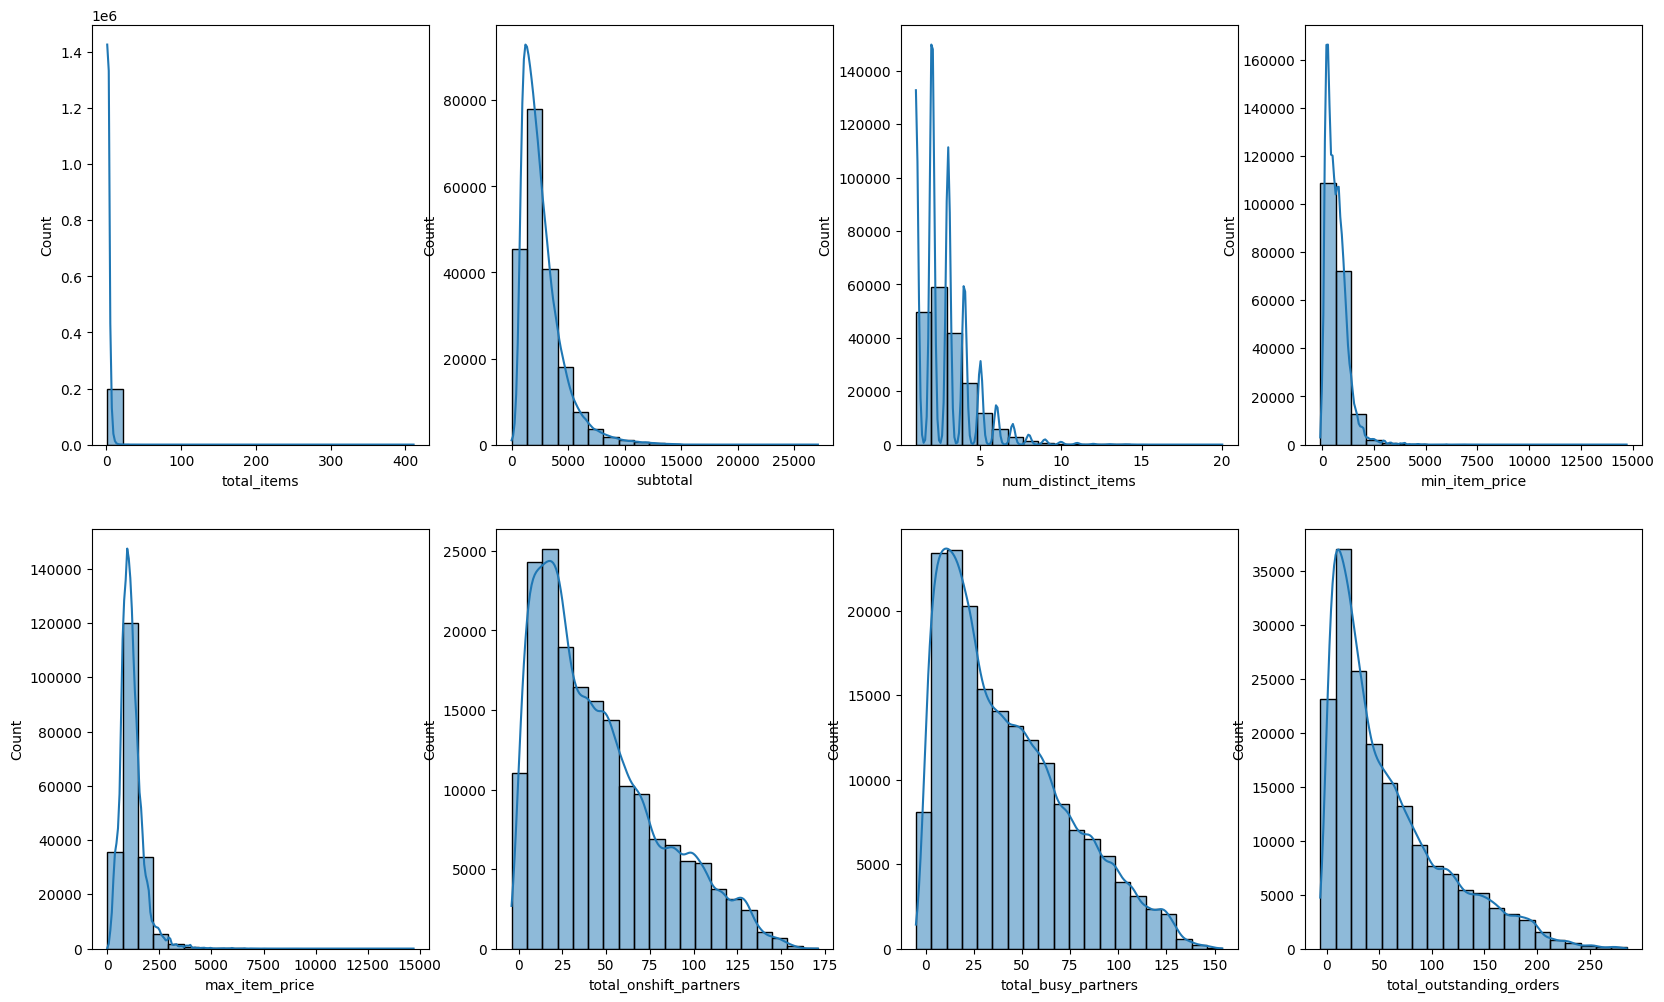

In [27]:

# Create a 2x4 grid of subplots with a specified figure size
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=(20, 12))

# Plot histograms for each variable in the specified subplots
sns.histplot(ax=ax1, x='total_items', data=df, kde=True, bins=20)
sns.histplot(ax=ax2, x='subtotal', data=df, kde=True, bins=20)
sns.histplot(ax=ax3, x='num_distinct_items', data=df, kde=True, bins=20)
sns.histplot(ax=ax4, x='min_item_price', data=df, kde=True, bins=20)
sns.histplot(ax=ax5, x='max_item_price', data=df, kde=True, bins=20)
sns.histplot(ax=ax6, x='total_onshift_partners', data=df, kde=True, bins=20)
sns.histplot(ax=ax7, x='total_busy_partners', data=df, kde=True, bins=20)
sns.histplot(ax=ax8, x='total_outstanding_orders', data=df, kde=True, bins=20)

# Display the plot
plt.show()

In [28]:
df.isna().sum()

market_id                     987
store_primary_category       4760
order_protocol                995
total_items                     0
subtotal                        0
num_distinct_items              0
min_item_price                  0
max_item_price                  0
total_onshift_partners      16262
total_busy_partners         16262
total_outstanding_orders    16262
Hour_of_day                     0
day_of_week                     0
Weekend_bool                    0
del_time                        0
min_max_avg_item_price          0
created_year                    0
created_month                   0
created_day                     0
created_hour                    0
created_minute                  0
delivery_year                   0
delivery_month                  0
delivery_day                    0
delivery_hour                   0
delivery_minute                 0
dtype: int64

In [29]:
df['store_primary_category'].unique()

array(['american', 'mexican', nan, 'indian', 'italian', 'sandwich',
       'thai', 'cafe', 'salad', 'pizza', 'chinese', 'singaporean',
       'burger', 'breakfast', 'mediterranean', 'japanese', 'greek',
       'catering', 'filipino', 'convenience-store', 'other', 'korean',
       'vegan', 'asian', 'barbecue', 'fast', 'dessert', 'smoothie',
       'seafood', 'vietnamese', 'cajun', 'steak', 'middle-eastern',
       'soup', 'vegetarian', 'persian', 'nepalese', 'sushi',
       'latin-american', 'hawaiian', 'chocolate', 'burmese', 'british',
       'pasta', 'alcohol', 'dim-sum', 'peruvian', 'turkish', 'malaysian',
       'ethiopian', 'afghan', 'bubble-tea', 'german', 'french',
       'caribbean', 'gluten-free', 'comfort-food', 'gastropub',
       'pakistani', 'moroccan', 'spanish', 'southern', 'tapas', 'russian',
       'brazilian', 'european', 'cheese', 'african', 'argentine',
       'kosher', 'irish', 'lebanese', 'belgian', 'indonesian',
       'alcohol-plus-food'], dtype=object)

### Fixing Mixing Values 1

In [30]:
# df.store_primary_category.fillna(df.store_primary_category.mode()[0], inplace=True)

# df.order_protocol.fillna(df.order_protocol.mean(), inplace=True)
# df.total_onshift_partners.fillna(df.total_onshift_partners.mean(), inplace=True)
# df.total_busy_partners.fillna(df.total_busy_partners.mean(), inplace=True)
# df.total_outstanding_orders.fillna(df.total_outstanding_orders.mean(), inplace=True)

### Fixing Mixing Values 2

In [31]:
df.isna().sum()

market_id                     987
store_primary_category       4760
order_protocol                995
total_items                     0
subtotal                        0
num_distinct_items              0
min_item_price                  0
max_item_price                  0
total_onshift_partners      16262
total_busy_partners         16262
total_outstanding_orders    16262
Hour_of_day                     0
day_of_week                     0
Weekend_bool                    0
del_time                        0
min_max_avg_item_price          0
created_year                    0
created_month                   0
created_day                     0
created_hour                    0
created_minute                  0
delivery_year                   0
delivery_month                  0
delivery_day                    0
delivery_hour                   0
delivery_minute                 0
dtype: int64

In [32]:
# Handle missing values

# Using Market_id to do missing value imputation makes a lot of sense

# Impute missing 'market_id' with a constant value (-1)
df['market_id'].fillna(-1, inplace=True)

# Group by 'market_id' and impute missing 'store_primary_category' with the mode of the group
df['store_primary_category'] = df.groupby('market_id')['store_primary_category'].transform(lambda x: x.fillna(x.mode()[0]))

# Group by 'market_id' and impute missing 'order_protocol' with the mode of the group
df['order_protocol'] = df.groupby('market_id')['order_protocol'].transform(lambda x: x.fillna(x.mode()[0]))

# Group by 'market_id' and impute missing 'total_onshift_partners', 'total_busy_partners', and 'total_outstanding_orders' with the median of the group
df['total_onshift_partners'] = df.groupby('market_id')['total_onshift_partners'].transform(lambda x: x.fillna(x.median()))
df['total_busy_partners'] = df.groupby('market_id')['total_busy_partners'].transform(lambda x: x.fillna(x.median()))
df['total_outstanding_orders'] = df.groupby('market_id')['total_outstanding_orders'].transform(lambda x: x.fillna(x.median()))


# Check for missing values
missing_values = df.isnull().sum()
print("Missing Values:")
print(missing_values)

Missing Values:
market_id                   0
store_primary_category      0
order_protocol              0
total_items                 0
subtotal                    0
num_distinct_items          0
min_item_price              0
max_item_price              0
total_onshift_partners      0
total_busy_partners         0
total_outstanding_orders    0
Hour_of_day                 0
day_of_week                 0
Weekend_bool                0
del_time                    0
min_max_avg_item_price      0
created_year                0
created_month               0
created_day                 0
created_hour                0
created_minute              0
delivery_year               0
delivery_month              0
delivery_day                0
delivery_hour               0
delivery_minute             0
dtype: int64


In [33]:
(df.total_onshift_partners==0).sum()

3615

In [34]:
df['total_available_partners'] = df['total_onshift_partners']-df['total_busy_partners']

In [35]:
df.columns

Index(['market_id', 'store_primary_category', 'order_protocol', 'total_items',
       'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price',
       'total_onshift_partners', 'total_busy_partners',
       'total_outstanding_orders', 'Hour_of_day', 'day_of_week',
       'Weekend_bool', 'del_time', 'min_max_avg_item_price', 'created_year',
       'created_month', 'created_day', 'created_hour', 'created_minute',
       'delivery_year', 'delivery_month', 'delivery_day', 'delivery_hour',
       'delivery_minute', 'total_available_partners'],
      dtype='object')

### Encoding categorical columns

In [36]:
df['store_primary_category_probab'] = df['store_primary_category'].map(df['store_primary_category'].value_counts(1).to_dict())

df['order_protocol_probab'] = df['order_protocol'].map(df['order_protocol'].value_counts(1).to_dict())

In [37]:
df.drop(columns=['store_primary_category'], inplace=True)


In [38]:
# Removing negative values from the numerical data as it doesn't make any sense neither there is any clarity on it
for i in df.describe().columns:
    if (i !='market_id') & (len(df.loc[df[i]<0].index)!=0):
        print(i)
        df.drop(index=df.loc[df[i]<0].index, inplace=True)
    # break

min_item_price
total_onshift_partners
total_busy_partners
total_outstanding_orders
total_available_partners


min_item_price
total_onshift_partners
total_busy_partners
total_outstanding_orders


## Data Visualization & cleaning

### Visualization - Countplots/ Scatterplots

In [39]:
categorical_cols.pop(categorical_cols.index('store_primary_category'))

'store_primary_category'

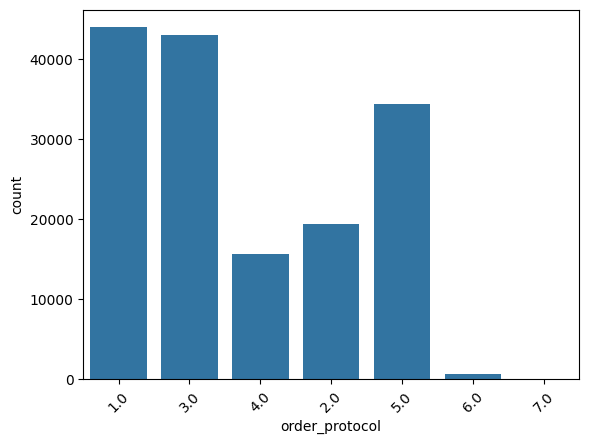

In [40]:
sns.countplot(x=df['order_protocol'].astype(str))
plt.xticks(rotation=45)
plt.show()

### Checking Outliers

In [41]:
df.describe()

,market_id,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders,...,created_hour,created_minute,delivery_year,delivery_month,delivery_day,delivery_hour,delivery_minute,total_available_partners,store_primary_category_probab,order_protocol_probab
count,156977.000000,156977.000000,156977.000000,156977.000000,156977.000000,156977.000000,156977.000000,156977.000000,156977.000000,156977.000000,...,156977.000000,156977.000000,156977.0,156977.000000,156977.000000,156977.000000,156977.000000,156977.000000,156977.000000,156977.000000
mean,3.077642,2.865649,3.210426,2689.978863,2.682883,683.839779,1157.875179,44.768030,39.056123,56.199144,...,8.369991,29.630991,2015.0,1.705122,14.886315,8.471317,29.434592,5.711907,0.051611,0.226768
std,1.581416,1.496349,2.718843,1836.183093,1.640900,520.052832,557.601220,34.425027,30.162517,51.803818,...,8.662103,17.372552,0.0,0.455989,8.842378,8.366850,17.350984,9.060799,0.033986,0.067489
min,-1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,2015.0,1.000000,1.000000,0.000000,0.000000,0.000000,0.000005,0.000096
25%,2.000000,1.000000,2.000000,1400.000000,1.000000,299.000000,800.000000,18.000000,14.000000,17.000000,...,2.000000,15.000000,2015.0,1.000000,8.000000,2.000000,14.000000,1.000000,0.027479,0.224338
50%,3.000000,3.000000,3.000000,2200.000000,2.000000,595.000000,1095.000000,36.000000,35.000000,43.000000,...,3.000000,29.000000,2015.0,2.000000,14.000000,4.000000,29.000000,2.000000,0.044433,0.273517
75%,4.000000,4.000000,4.000000,3400.000000,3.000000,945.000000,1395.000000,64.000000,57.000000,79.000000,...,19.000000,45.000000,2015.0,2.000000,23.000000,19.000000,44.000000,7.000000,0.092153,0.278172
max,6.000000,7.000000,411.000000,27100.000000,20.000000,14700.000000,14700.000000,171.000000,148.000000,285.000000,...,23.000000,59.000000,2015.0,2.000000,31.000000,23.000000,59.000000,86.000000,0.109639,0.278172


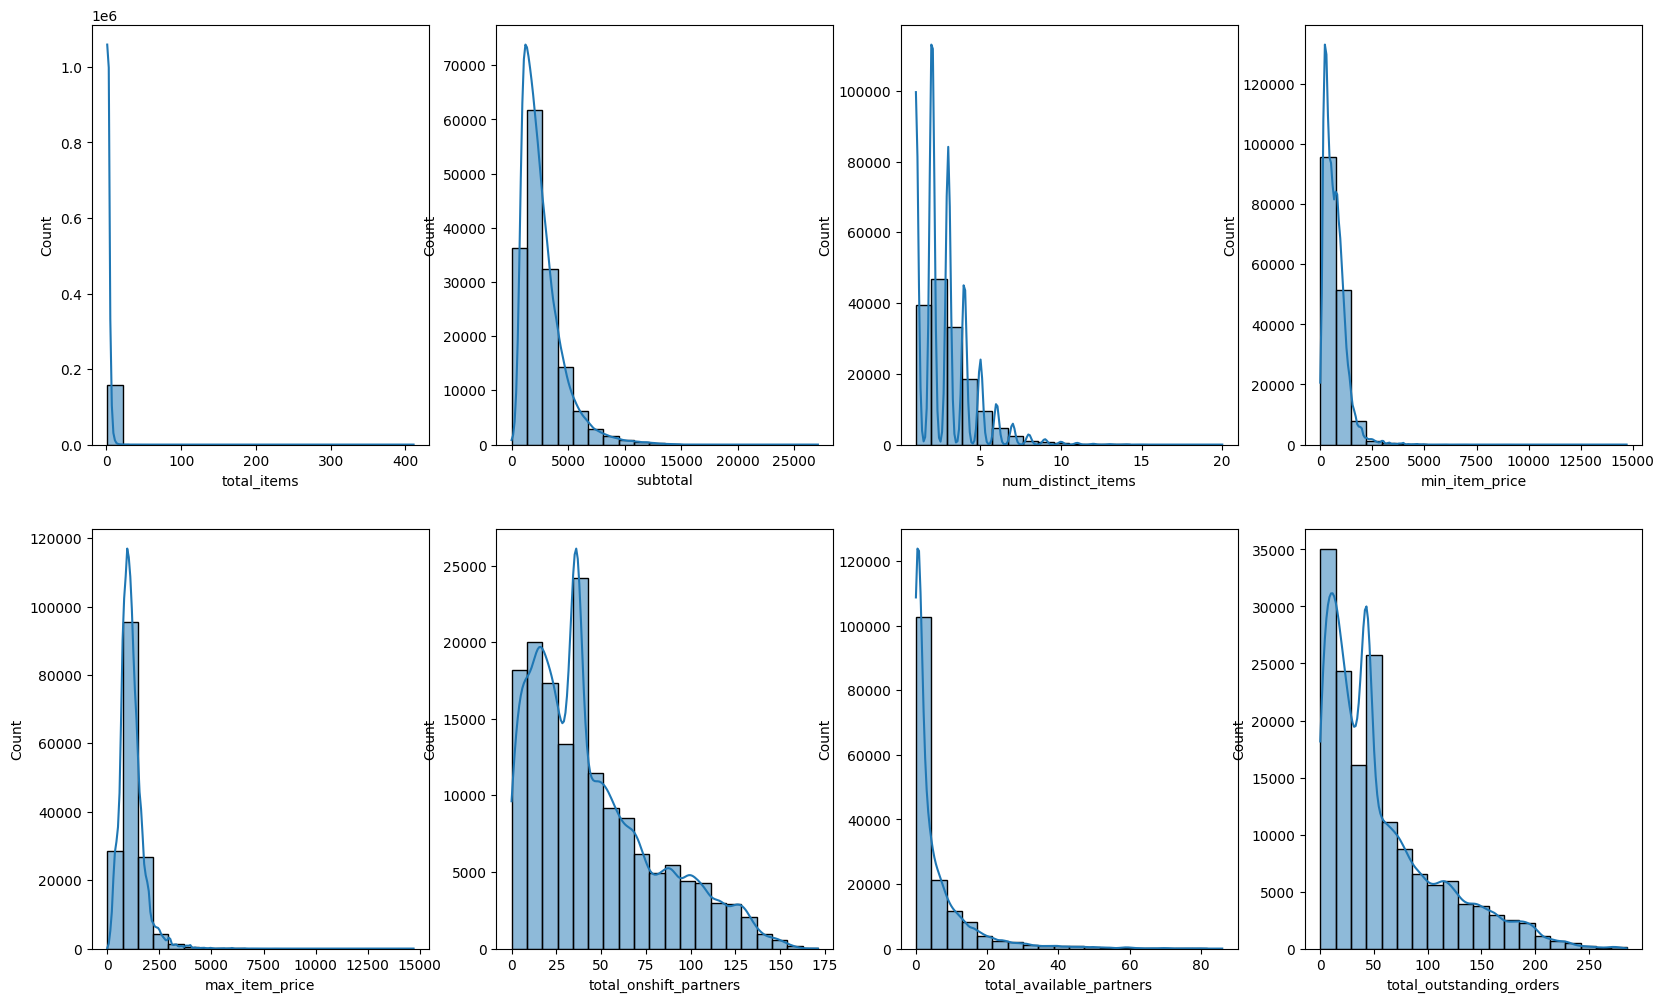

In [42]:
# Create a 2x4 grid of subplots with a specified figure size
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=(20, 12))

# Plot histograms for each variable in the specified subplots
sns.histplot(ax=ax1, x='total_items', data=df, kde=True, bins=20)
sns.histplot(ax=ax2, x='subtotal', data=df, kde=True, bins=20)
sns.histplot(ax=ax3, x='num_distinct_items', data=df, kde=True, bins=20)
sns.histplot(ax=ax4, x='min_item_price', data=df, kde=True, bins=20)
sns.histplot(ax=ax5, x='max_item_price', data=df, kde=True, bins=20)
sns.histplot(ax=ax6, x='total_onshift_partners', data=df, kde=True, bins=20)
sns.histplot(ax=ax7, x='total_available_partners', data=df, kde=True, bins=20)
sns.histplot(ax=ax8, x='total_outstanding_orders', data=df, kde=True, bins=20)

# Display the plot
plt.show()

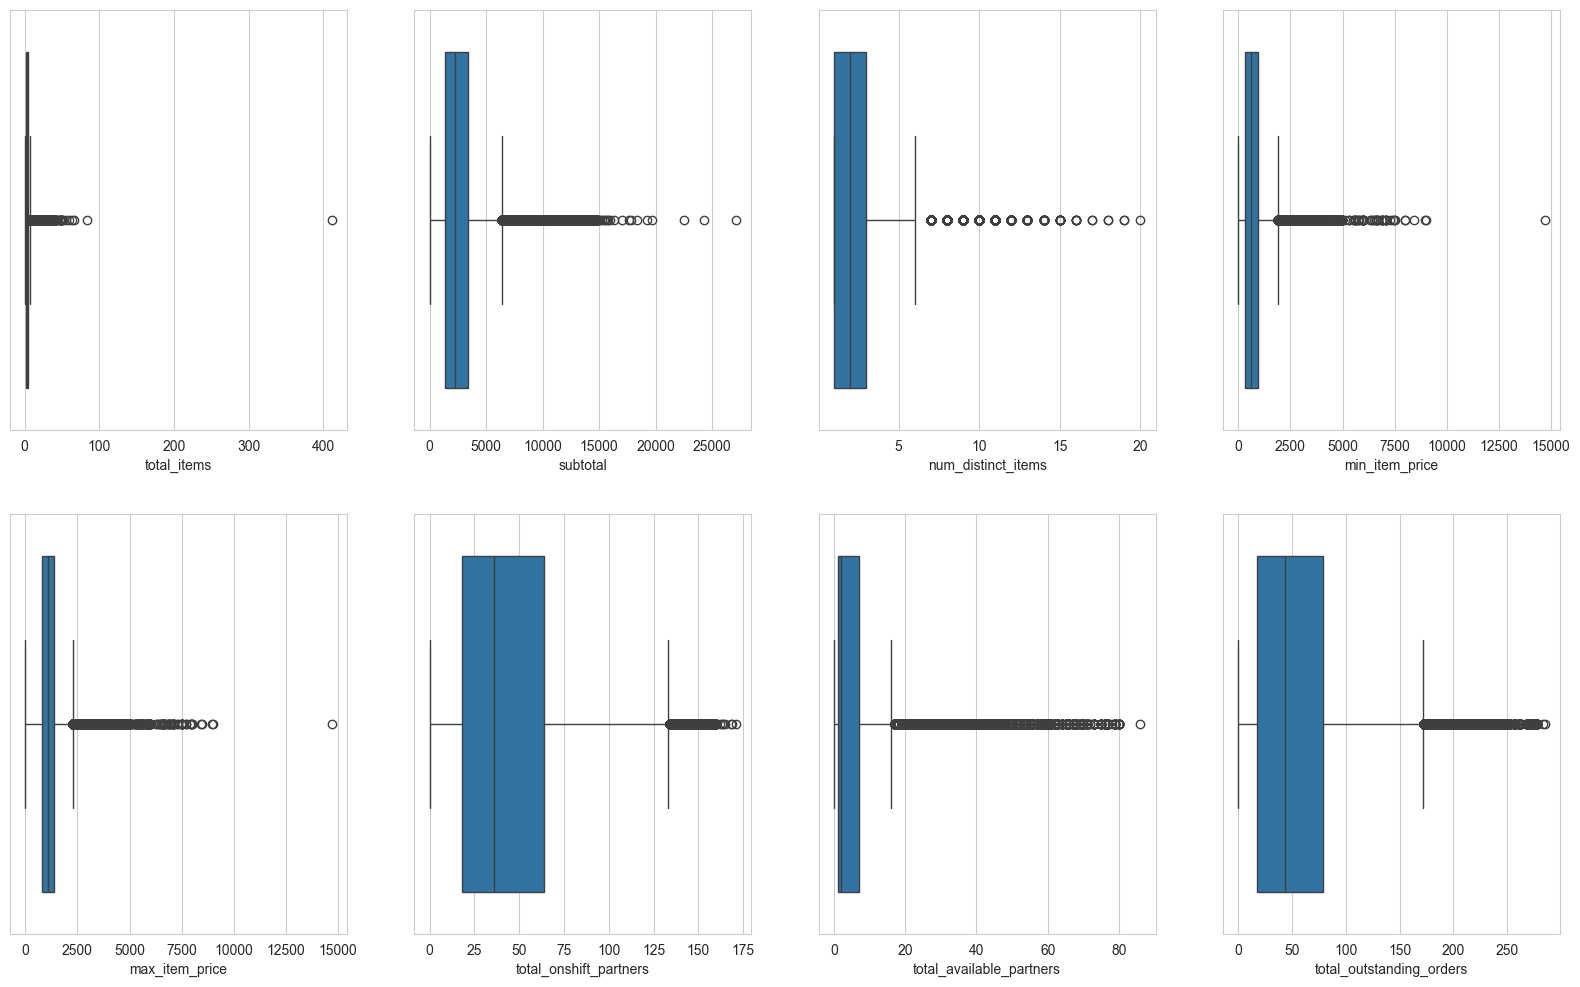

In [43]:
# Set the Seaborn style to 'whitegrid'
sns.set_style('whitegrid')

# Create a 2x4 grid of subplots with a specified figure size
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=(20, 12))

# Create box plots for each variable in the specified subplots
sns.boxplot(ax=ax1, x='total_items', data=df)
sns.boxplot(ax=ax2, x='subtotal', data=df)
sns.boxplot(ax=ax3, x='num_distinct_items', data=df)
sns.boxplot(ax=ax4, x='min_item_price', data=df)
sns.boxplot(ax=ax5, x='max_item_price', data=df)
sns.boxplot(ax=ax6, x='total_onshift_partners', data=df)
sns.boxplot(ax=ax7, x='total_available_partners', data=df)
sns.boxplot(ax=ax8, x='total_outstanding_orders', data=df)

# Display the plot
plt.show()

### Removing Outliers by IQR method

In [44]:
# Calculate the interquartile range (IQR) for each variable
Q1 = df[['total_items', 'subtotal', 'min_item_price', 'max_item_price', 'total_onshift_partners']].quantile(0.25)
Q3 = df[['total_items', 'subtotal', 'min_item_price', 'max_item_price', 'total_onshift_partners']].quantile(0.75)
IQR = Q3 - Q1

# Display the calculated IQR
print(IQR)

total_items                  2.0
subtotal                  2000.0
min_item_price             646.0
max_item_price             595.0
total_onshift_partners      46.0
dtype: float64


In [45]:
Lower = Q1-3.0*IQR
Upper = Q3+3.0*IQR

In [46]:
# Create boolean conditions for each variable using IQR boundaries
c0 = (df['total_items'] >= Lower['total_items']) & (df['total_items'] <= Upper['total_items'])
c1 = (df['subtotal'] >= Lower['subtotal']) & (df['subtotal'] <= Upper['subtotal'])
c3 = (df['min_item_price'] >= Lower['min_item_price']) & (df['min_item_price'] <= Upper['min_item_price'])
c4 = (df['max_item_price'] >= Lower['max_item_price']) & (df['max_item_price'] <= Upper['max_item_price'])
c5 = (df['total_onshift_partners'] >= Lower['total_onshift_partners']) & (df['total_onshift_partners'] <= Upper['total_onshift_partners'])
# c6 = (df['total_busy_partners'] >= Lower['total_busy_partners']) & (df['total_busy_partners'] <= Upper['total_busy_partners'])
# c7 = (df['total_outstanding_orders'] >= Lower['total_outstanding_orders']) & (df['total_outstanding_orders'] <= Upper['total_outstanding_orders'])

# Filter the DataFrame based on the combined boolean conditions
df = df[c0 & c1 & c3 & c4 & c5]

# Display the updated shape of the DataFrame
print("Shape after outlier removal:", df.shape)

Shape after outlier removal: (151625, 28)


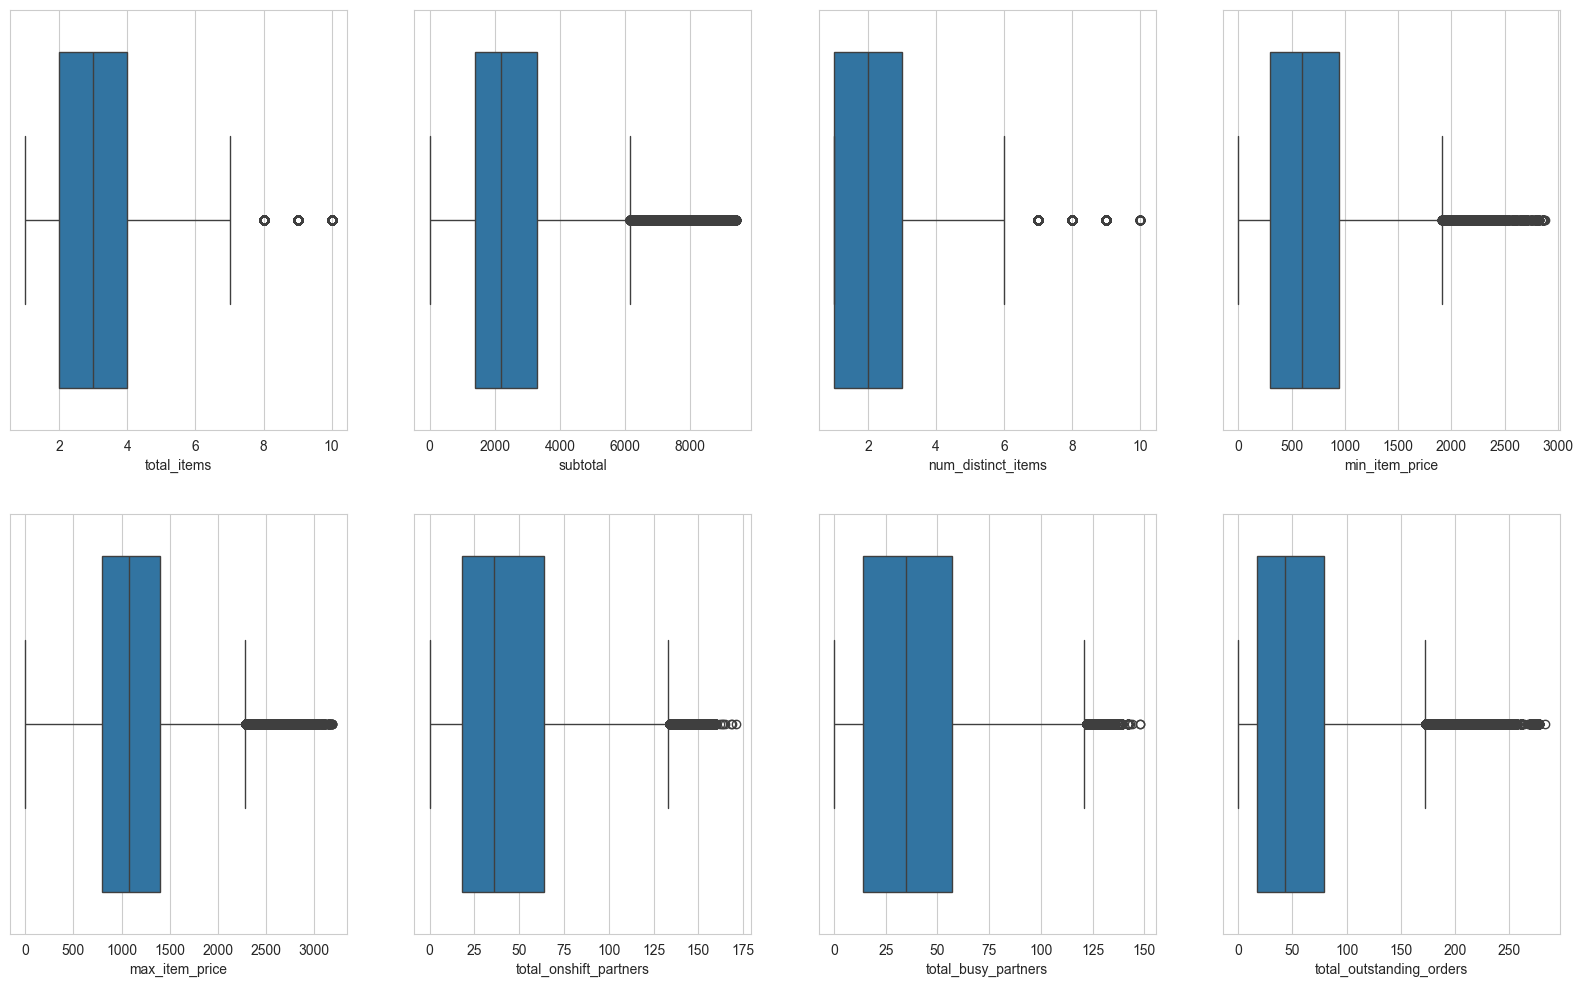

In [47]:
# Create a 2x4 grid of subplots with a specified figure size
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=(20, 12))

# Create box plots for each variable in the specified subplots
sns.boxplot(ax=ax1, x='total_items', data=df)
sns.boxplot(ax=ax2, x='subtotal', data=df)
sns.boxplot(ax=ax3, x='num_distinct_items', data=df)
sns.boxplot(ax=ax4, x='min_item_price', data=df)
sns.boxplot(ax=ax5, x='max_item_price', data=df)
sns.boxplot(ax=ax6, x='total_onshift_partners', data=df)
sns.boxplot(ax=ax7, x='total_busy_partners', data=df)
sns.boxplot(ax=ax8, x='total_outstanding_orders', data=df)

# Display the plot
plt.show()

In [48]:
# Select the columns containing numerical variables
numerical_df = df[numerical_cols]

numerical_df.skew()

total_items                   1.237803
subtotal                      1.330955
num_distinct_items            1.112138
min_item_price                1.099834
max_item_price                0.885328
total_onshift_partners        0.942714
total_busy_partners           0.885469
total_outstanding_orders      1.300543
del_time                    385.897702
dtype: float64

In [49]:
numerical_df.kurt()

total_items                      1.523233
subtotal                         1.933319
num_distinct_items               1.350227
min_item_price                   1.530273
max_item_price                   1.377906
total_onshift_partners           0.158956
total_busy_partners              0.128527
total_outstanding_orders         1.175518
del_time                    149786.664174
dtype: float64

In [50]:
df.columns

Index(['market_id', 'order_protocol', 'total_items', 'subtotal',
       'num_distinct_items', 'min_item_price', 'max_item_price',
       'total_onshift_partners', 'total_busy_partners',
       'total_outstanding_orders', 'Hour_of_day', 'day_of_week',
       'Weekend_bool', 'del_time', 'min_max_avg_item_price', 'created_year',
       'created_month', 'created_day', 'created_hour', 'created_minute',
       'delivery_year', 'delivery_month', 'delivery_day', 'delivery_hour',
       'delivery_minute', 'total_available_partners',
       'store_primary_category_probab', 'order_protocol_probab'],
      dtype='object')

In [51]:
numerical_cols.extend(['store_primary_category_probab', 'order_protocol_probab', 'min_max_avg_item_price', 'total_available_partners', 'Hour_of_day', 'day_of_week', 'order_protocol'])



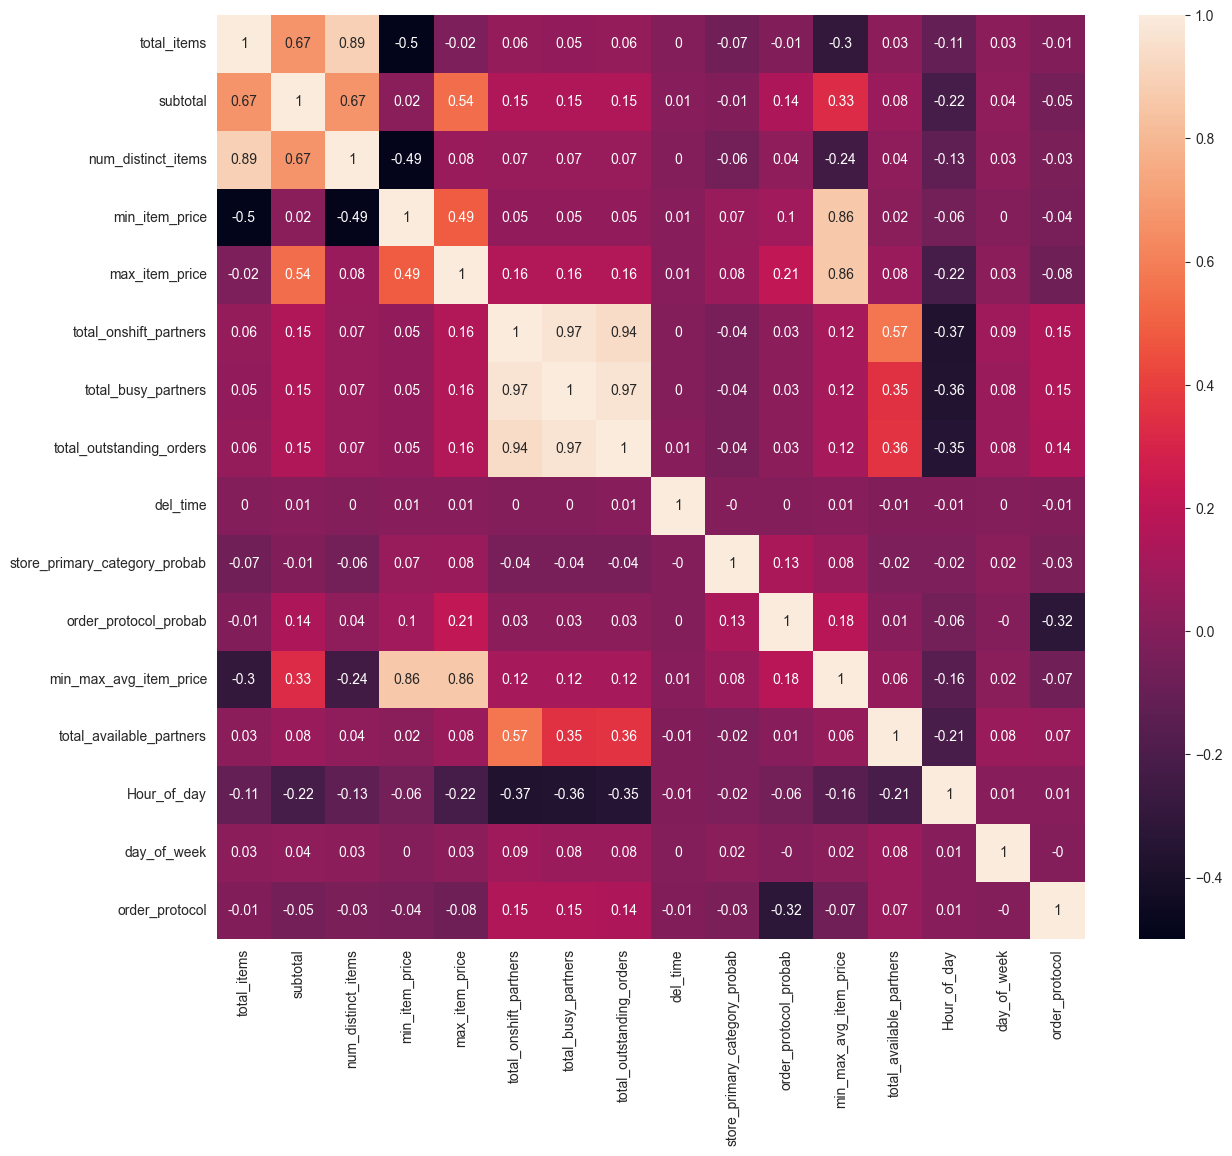

In [52]:

# Calculate and round the correlation matrix between the interval variables
correlation_matrix = df[numerical_cols].corr().round(2)

# Display the correlation matrix
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True)
plt.show()

In [53]:
df.columns

Index(['market_id', 'order_protocol', 'total_items', 'subtotal',
       'num_distinct_items', 'min_item_price', 'max_item_price',
       'total_onshift_partners', 'total_busy_partners',
       'total_outstanding_orders', 'Hour_of_day', 'day_of_week',
       'Weekend_bool', 'del_time', 'min_max_avg_item_price', 'created_year',
       'created_month', 'created_day', 'created_hour', 'created_minute',
       'delivery_year', 'delivery_month', 'delivery_day', 'delivery_hour',
       'delivery_minute', 'total_available_partners',
       'store_primary_category_probab', 'order_protocol_probab'],
      dtype='object')

### Split the data to train, val and test datasets

In [54]:
X = df.drop(columns=['del_time'])
y = df['del_time']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [55]:
df.head()

,market_id,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders,...,created_hour,created_minute,delivery_year,delivery_month,delivery_day,delivery_hour,delivery_minute,total_available_partners,store_primary_category_probab,order_protocol_probab
0,1.0,1.0,4,3441,4,557,1239,33.0,14.0,21.0,...,22,24,2015.0,2.0,6.0,23.0,27.0,19.0,0.109639,0.278172
2,3.0,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,...,20,39,2015.0,1.0,22.0,21.0,9.0,1.0,0.109639,0.278172
3,3.0,1.0,6,6900,5,600,1800,1.0,1.0,2.0,...,21,21,2015.0,2.0,3.0,22.0,13.0,0.0,0.109639,0.278172
4,3.0,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,...,2,40,2015.0,2.0,15.0,3.0,20.0,0.0,0.109639,0.278172
5,3.0,1.0,3,5000,3,1500,1900,2.0,2.0,2.0,...,20,30,2015.0,1.0,28.0,21.0,8.0,0.0,0.109639,0.278172


## Modeling

### Base Model

In [56]:
X.isna().sum()

market_id                        0
order_protocol                   0
total_items                      0
subtotal                         0
num_distinct_items               0
min_item_price                   0
max_item_price                   0
total_onshift_partners           0
total_busy_partners              0
total_outstanding_orders         0
Hour_of_day                      0
day_of_week                      0
Weekend_bool                     0
min_max_avg_item_price           0
created_year                     0
created_month                    0
created_day                      0
created_hour                     0
created_minute                   0
delivery_year                    0
delivery_month                   0
delivery_day                     0
delivery_hour                    0
delivery_minute                  0
total_available_partners         0
store_primary_category_probab    0
order_protocol_probab            0
dtype: int64

In [57]:
rf = RandomForestRegressor(max_depth=8, n_estimators=100, criterion='squared_error', random_state=42)

rf.fit(X_train, y_train)
feat_imp_series = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
feat_imp_series.iloc[:10]

created_month               0.469085
delivery_hour               0.257098
created_year                0.149808
created_hour                0.028445
Hour_of_day                 0.027571
delivery_minute             0.023071
created_minute              0.019842
total_available_partners    0.008016
total_outstanding_orders    0.003798
subtotal                    0.003604
dtype: float64

In [59]:
y_pred = rf.predict(X_val)

metrics_evals(y_pred=y_pred, y_true=y_val, X_test=X_val)

# mse= 17276.82980714839
# rmse= 131.44135501107857
# mae= 13.725309712726052
# r2= -43.518131698823574

{'MSE': 2955.8963751916585,
 'RMSE': 54.36815589287224,
 'MAE': 10.141212237729075,
 'R2': 0.055671540766209726,
 'ADJ_R2': 0.05379938654054617}

In [60]:
y_pred = rf.predict(X_test)

metrics_evals(y_pred=y_pred, y_true=y_test, X_test=X_test)

{'MSE': 178.1367781894783,
 'RMSE': 13.346789059151204,
 'MAE': 9.637614440065942,
 'R2': 0.45968206877097006,
 'ADJ_R2': 0.4587181715695704}

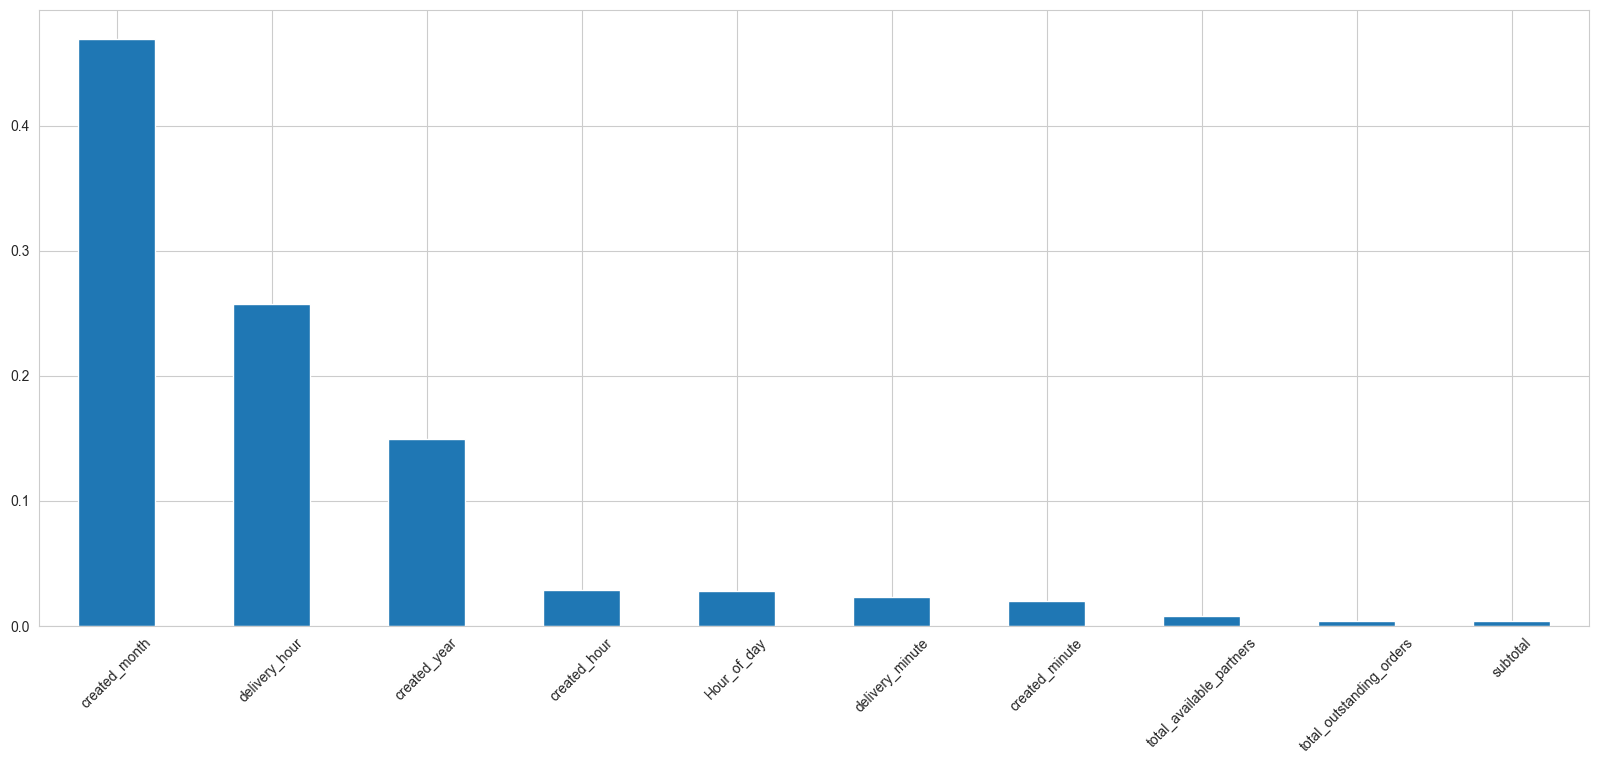

In [61]:

feat_imp_series.iloc[:10].plot(kind='bar',rot=45, figsize=(20,8))
plt.show()


- the delivery time is generally affected by the quantity of items to be delivered, its weight, its value (more value might need special packaging or may not), the rush during the time of delivery

### Scaling data for NN

In [62]:
sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)
X_test = sc.transform(X_test)

### Simple NN Model

In [69]:
## Baseline Model Generator for NN

def create_baseline(activation_function='relu',
                    kernel_initializer='he_uniform'):

  # model = Sequential([
  #                   Dense(32, activation=activation_function,kernel_initializer='he_uniform'),
  #                   Dense(64, activation=activation_function,kernel_initializer='he_uniform'),
  #                   Dense(128, activation=activation_function,kernel_initializer='he_uniform'),
  #                   Dense(64, activation=activation_function,kernel_initializer='he_uniform'),
  #                   Dense(32, activation=activation_function,kernel_initializer='he_uniform'),
  #                   Dense(1, input_shape=(1,))])
#   model = Sequential([
#       Dense(64, activation=activation_function, kernel_initializer=kernel_initializer, input_shape=(X_train.shape[1],)),
#       Dense(256,activation=activation_function, kernel_initializer=kernel_initializer),      
#       Dense(512, activation=activation_function, kernel_initializer=kernel_initializer),
#       Dense(256,activation=activation_function, kernel_initializer=kernel_initializer),
#       Dense(64,activation=activation_function, kernel_initializer=kernel_initializer),      
#       Dense(1,activation='linear') # Since it's a regression task, use 1 output neuron
#   ])  
  model = Sequential([
      Dense(64, activation=activation_function, kernel_initializer=kernel_initializer, input_shape=(X_train.shape[1],)),
      Dense(256,activation=activation_function, kernel_initializer=kernel_initializer),      
      Dense(512, activation=activation_function, kernel_initializer=kernel_initializer),
      Dense(1024, activation=activation_function, kernel_initializer=kernel_initializer),      
      Dense(512, activation=activation_function, kernel_initializer=kernel_initializer),      
      Dense(256,activation=activation_function, kernel_initializer=kernel_initializer),
      Dense(64,activation=activation_function, kernel_initializer=kernel_initializer),      
      Dense(1,activation='linear') # Since it's a regression task, use 1 output neuron
  ])    
  return model

### Exploring Activation Functions

Epoch 1/200
480/480 [==============================] - 12s 21ms/step - loss: 155981.1094 - mae: 15.2958 - mse: 155981.1094 - val_loss: 3071.8223 - val_mae: 12.0199 - val_mse: 3071.8223
Epoch 2/200
480/480 [==============================] - 10s 22ms/step - loss: 109945.2266 - mae: 13.0712 - mse: 109945.2266 - val_loss: 3049.1931 - val_mae: 10.9917 - val_mse: 3049.1931
Epoch 3/200
480/480 [==============================] - 11s 23ms/step - loss: 52816228.0000 - mae: 30.3923 - mse: 52816228.0000 - val_loss: 3011.1836 - val_mae: 9.2730 - val_mse: 3011.1836
Epoch 4/200
480/480 [==============================] - 11s 23ms/step - loss: 152866.8750 - mae: 11.4461 - mse: 152866.8750 - val_loss: 3003.7498 - val_mae: 8.7393 - val_mse: 3003.7498
Epoch 5/200
480/480 [==============================] - 12s 24ms/step - loss: 141226.3281 - mae: 10.9780 - mse: 141226.3281 - val_loss: 3001.5247 - val_mae: 8.4792 - val_mse: 3001.5247
Epoch 6/200
480/480 [==============================] - 11s 23ms/step - los

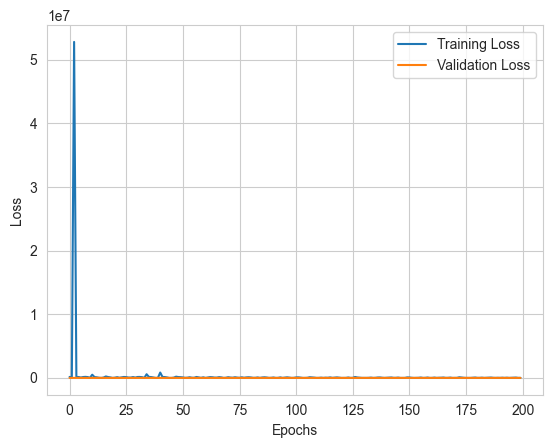

CPU times: user 2h 55min 22s, sys: 42min 23s, total: 3h 37min 46s
Wall time: 45min 10s


In [71]:
%%time
try:
  del model
except:
  print("No Model")

model = create_baseline(activation_function='relu', kernel_initializer='he_uniform')

model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse', "acc"])
history = model.fit(X_train, y_train, epochs=200, batch_size=256, validation_data = (X_val, y_val))

y_pred = model.predict(X_test)

print(metrics_evals(y_pred=y_pred, y_true=y_test, X_test=X_test))


# Step 7: Plot the training loss and validation loss over epochs
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

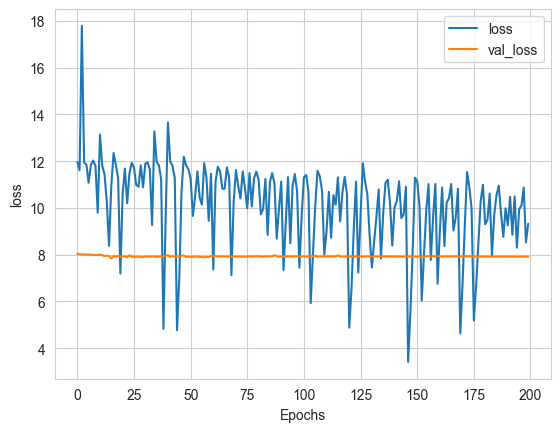

In [72]:
def plot_history(history,key):
    plt.plot(np.log(history.history[key]))
    plt.plot(np.log(history.history['val_'+key]))
    plt.xlabel("Epochs")
    plt.ylabel(key)
    plt.legend([key,'val_'+key])
    plt.show()

# plot the history
plot_history(history=history,key='loss')

Epoch 1/200
480/480 - 4s - loss: 164885.9531 - mae: 16.1094 - mse: 164885.9531 - val_loss: 3130.2290 - val_mae: 13.7825 - val_mse: 3130.2290 - 4s/epoch - 9ms/step
Epoch 2/200
480/480 - 3s - loss: 164787.3281 - mae: 14.5295 - mse: 164787.3281 - val_loss: 3130.7507 - val_mae: 13.7058 - val_mse: 3130.7507 - 3s/epoch - 6ms/step
Epoch 3/200
480/480 - 3s - loss: 164783.5000 - mae: 14.5213 - mse: 164783.5000 - val_loss: 3130.5630 - val_mae: 13.7251 - val_mse: 3130.5630 - 3s/epoch - 6ms/step
Epoch 4/200
480/480 - 3s - loss: 164782.2969 - mae: 14.5272 - mse: 164782.2969 - val_loss: 3130.1877 - val_mae: 13.7983 - val_mse: 3130.1877 - 3s/epoch - 6ms/step
Epoch 5/200
480/480 - 3s - loss: 164782.1250 - mae: 14.5330 - mse: 164782.1250 - val_loss: 3130.3848 - val_mae: 13.7493 - val_mse: 3130.3848 - 3s/epoch - 6ms/step
Epoch 6/200
480/480 - 3s - loss: 164780.3750 - mae: 14.5322 - mse: 164780.3750 - val_loss: 3130.5083 - val_mae: 13.7318 - val_mse: 3130.5083 - 3s/epoch - 6ms/step
Epoch 7/200
480/480 - 

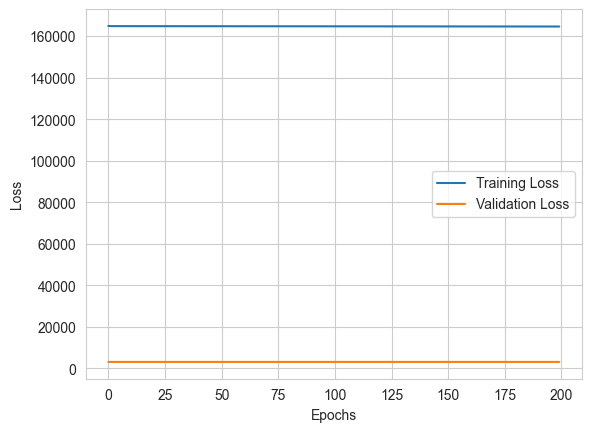

CPU times: user 50min 11s, sys: 13min 39s, total: 1h 3min 51s
Wall time: 14min 12s


In [68]:
%%time
try:
  del model
except:
  print("No Model")

adam_optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.01,
    beta_1=0.9,
    beta_2=0.99,
    name='Adam',
)


model = create_baseline(activation_function='tanh', kernel_initializer='glorot_uniform')

model.compile(optimizer=adam_optimizer, loss='mean_squared_error', metrics=['mae', 'mse'])
history1 = model.fit(X_train, y_train, epochs=200, batch_size=256, validation_data = (X_val, y_val), verbose=2)

y_pred = model.predict(X_test)

print(metrics_evals(y_pred=y_pred, y_true=y_test, X_test=X_test))


# Step 7: Plot the training loss and validation loss over epochs
import matplotlib.pyplot as plt

plt.plot(history1.history['loss'], label='Training Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



Here's a comparison of the results between the Random Forest Regressor and the Simple Neural Network model:

**Random Forest Regressor:**


- Mean Squared Error (MSE): 16005.80
- Mean Absolute Error (MAE): 13.29
- R-squared (R2): -43.82



**Simple Neural Network Model (Best):**

- Mean Squared Error (MSE): 321.5109166532791
- Mean Absolute Error (MAE): 12.468098981433444
- R-squared (R2): 0.13218877933924755


**Comparison:**

The Random Forest Regressor has significantly higher MSE, MAE, and RMSE values compared to the Simple Neural Network model. This indicates that the Random Forest model performs better in terms of accuracy and error metrics.

The R-squared value for the Neural Network model is comparitvely better but it is still underfitting (0.928), indicating that it explains a some portion of the variance in the target variable.

In this specific scenario, the Random Forest Regressor might perform better upon passing standard normalized data. However, it's essential to consider that the performance of these models can vary depending on the dataset and problem we are working on. Further optimization and tuning of the neural network model may lead to improved results.

The given experimentation show cases of underfitting model.